### Preliminaries

In [46]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from scipy.interpolate import griddata


### Coordinate detection

In [35]:
def detect_dots(image_path):
    """
    Detect neon-green or red dots in an image using HSV thresholding + connected components.
    Creates an annotated image with numbered points and saves the coordinates to a CSV file.
    """
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Could not read image: {image_path}")

    # Convert to HSV
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # If image is rubik's cube
    if os.path.basename(image_path)[1] == 'r': 
        # Define HSV threshold range for red points; Note: red wraps around the hue range
        lower_red1 = np.array([0, 150, 150])
        upper_red1 = np.array([5, 255, 255])

        lower_red2 = np.array([170, 150, 150])
        upper_red2 = np.array([179, 255, 255])

        # Create masks for both red ranges
        mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
        mask2 = cv2.inRange(hsv, lower_red2, upper_red2)

        # Combine masks
        mask = cv2.bitwise_or(mask1, mask2)

    #Image is tsai board 
    else:
        # Define HSV threshold range for neon green points
        lower_green = np.array([40, 100, 100])
        upper_green = np.array([80, 255, 255])

        # Apply threshold
        mask = cv2.inRange(hsv, lower_green, upper_green)

    # Morphological cleaning
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

    # Connected components
    num, labels, stats, centroids = cv2.connectedComponentsWithStats(mask)

    points = []
    for i in range(1, num):  # skip background
        cx, cy = centroids[i]
        points.append((int(cx), int(cy)))

    df = pd.DataFrame(points, columns=["x0", "y0"])

    for i, (x, y) in enumerate(points):  
        # Draw a circle for the point
        cv2.circle(img, (x, y), radius=5, color=(0, 255, 0), thickness=-1)
        # Put text next to the point
        cv2.putText(img, str(i), (x+10, y-10), cv2.FONT_HERSHEY_SIMPLEX, 
                2, (0, 0, 255), 3)

    # Save detected image in "detectedpics" folder
    filename = os.path.basename(image_path)
    imgname = os.path.splitext(filename)[0]
    output_folder = "detectedpics"
    os.makedirs(output_folder, exist_ok=True)
    img_out_path = os.path.join(output_folder, f"det_{imgname}.jpg")
    cv2.imwrite(img_out_path, img)


    #cv2.imshow("Annotated", img)
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()
    csv_path = os.path.join("detections", f"{imgname}.csv")
    df.to_csv(csv_path, index=False)
    return df.head()

In [36]:
for files in os.listdir('pics'):
    if files.endswith('.jpg'):
        detect_dots(os.path.join('pics', files))



In [37]:
print(pd.read_csv('detections/3r.csv').head())

    x0    y0
0  436  1323
1  520  1329
2  598  1351
3  670  1354
4  575  1368


In [7]:
img = cv2.imread('moreannopics/3.jpg')
if img is None:
    raise ValueError("Could not read image: moreannopics/3.jpg")
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

print(hsv)  

[[[ 30  10 197]
  [ 30  10 203]
  [ 30  10 206]
  ...
  [ 35   8 188]
  [ 35   8 190]
  [ 35   8 191]]

 [[ 30  10 201]
  [ 30  10 205]
  [ 30  10 208]
  ...
  [ 35   8 188]
  [ 35   8 186]
  [ 35   8 182]]

 [[ 30  10 205]
  [ 30  10 208]
  [ 30  10 209]
  ...
  [ 35   8 190]
  [ 35   8 190]
  [ 35   8 190]]

 ...

 [[  9 100 123]
  [  9 100 122]
  [  9 101 121]
  ...
  [ 30   3 187]
  [ 30   3 187]
  [ 30   3 188]]

 [[  9 101 121]
  [  9 102 120]
  [  9 103 119]
  ...
  [ 30   3 187]
  [ 30   3 187]
  [ 30   3 186]]

 [[  9 100 122]
  [  9 101 121]
  [  9 103 119]
  ...
  [ 30   3 185]
  [ 30   3 185]
  [ 30   3 185]]]


### 3D Recreation

In [ ]:
df1 = detect_green_dots('moreannopics/3.jpg')
df2 = detect_green_dots('moreannopics/5.jpg')

df1['x1'] = df2['x0']
df1 = df1[['y0', 'x0', 'x1']]

df1 = df1[10:40] 
df1

In [23]:
arr0 = df1['y0'].to_numpy()
arr1 = df1['x0'].to_numpy()
arr2 = df1['x1'].to_numpy()

arr0 = np.reshape(arr0, (6, 5))
arr1 = np.reshape(arr1, (6, 5))
arr2 = np.reshape(arr2, (6, 5))

In [27]:
arr1

array([[ 336,  638,  894,  210, 1004],
       [ 640,  335,  895,  638,  215],
       [1007,  338,  894,  639,  219],
       [1005,  339,  895,  637,  217],
       [1007,  340,  895,  641, 1006],
       [ 221,  342,  899,  638,  689]], dtype=int64)

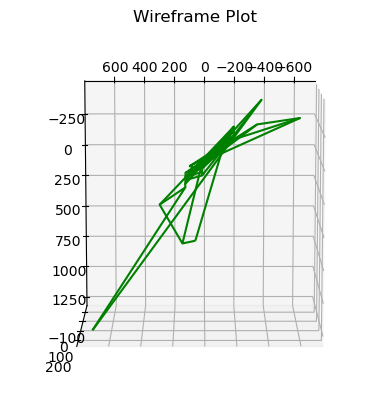

In [25]:
# focal length of camera
f = 200
# camera transverse distance
b = 100
# position of points in reference images
num_pts = 10
c = 128

# convert to numpy arrays
x1 = arr1
x2 = arr2
y = arr0
# calculation of depth
Z = b * f / (x2 - x1)

# 3D Position Calculation
X = (x1 - c) * (Z / f)
Y = (y - c) * (Z / f)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_wireframe(X, Y, Z, color='green')
ax.set_title('Wireframe Plot')

ax.view_init(100, 90, 0)
plt.show()

## 3D Recreation with Surface

### Image 3 and 5

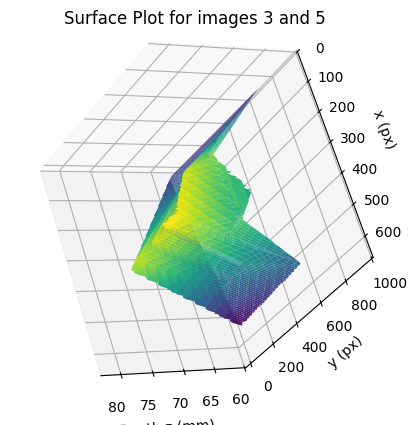

[-315 -333 -254 -292 -301 -249 -293 -295 -253 -289 -295 -248 -286 -289
 -249 -285 -288 -242 -282 -278 -244 -283 -257 -267 -248 -265 -285 -283
 -258 -263 -277 -299 -318]


In [81]:
# focal length of camera
f = 200
# camera transverse distance
b = 100
# position of points in reference images
num_pts = 10
c = 128

x1 = pd.read_csv('detections/3.csv')['x0'].to_numpy()
y = pd.read_csv('detections/3.csv')['y0'].to_numpy()
x2 = pd.read_csv('detections/5.csv')['x0'].to_numpy()

# Manually adjust to match points
x2[32], x2[31] = x2[31], x2[32]
x2[21], x2[22] = x2[22], x2[21]

# calculation of depth
Z = b * f / (x2 - x1)

# 3D Position Calculation
X = (x1 - c) * (Z / f)
Y = (y - c) * (Z / f)

grid_x, grid_y = np.mgrid[min(X.flatten()):max(X.flatten()):200j, min(Y.flatten()):max(Y.flatten()):200j]
grid_z = griddata((X.flatten(), Y.flatten()), Z.flatten(), (grid_x, grid_y), method='linear')

# Plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(grid_x, grid_y, grid_z, cmap='viridis')
ax.set_xlabel("x (px)")
ax.set_ylabel("y (px)")
ax.set_zlabel("Depth z (mm)")
ax.set_title('Surface Plot for images 3 and 5')

ax.view_init(35, 60, 90)


plt.show()

print(x1-x2)

### Image 3 and 4

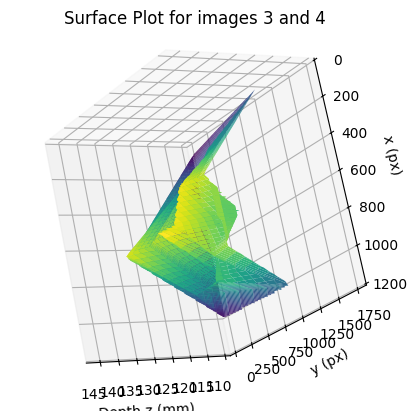

[-183 -181 -143 -164 -162 -138 -167 -157 -142 -164 -158 -140 -163 -156
 -142 -159 -156 -135 -155 -147 -137 -154 -144 -148 -137 -143 -155 -152
 -140 -142 -149 -165 -168]


In [82]:
#Try it for image 4
x2 = pd.read_csv('detections/4.csv')['x0'].to_numpy()

# Manually adjust to match points
x2[21], x2[22] = x2[22], x2[21]

# calculation of depth
Z = b * f / (x2 - x1)

# 3D Position Calculation
X = (x1 - c) * (Z / f)
Y = (y - c) * (Z / f)

grid_x, grid_y = np.mgrid[min(X.flatten()):max(X.flatten()):200j, min(Y.flatten()):max(Y.flatten()):200j]
grid_z = griddata((X.flatten(), Y.flatten()), Z.flatten(), (grid_x, grid_y), method='linear')

# Plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(grid_x, grid_y, grid_z, cmap='viridis')
ax.set_xlabel("x (px)")
ax.set_ylabel("y (px)")
ax.set_zlabel("Depth z (mm)")
ax.set_title('Surface Plot for images 3 and 4')

ax.view_init(35, 70, 90)

plt.show()

print(x1-x2)

### Image 3 and 6

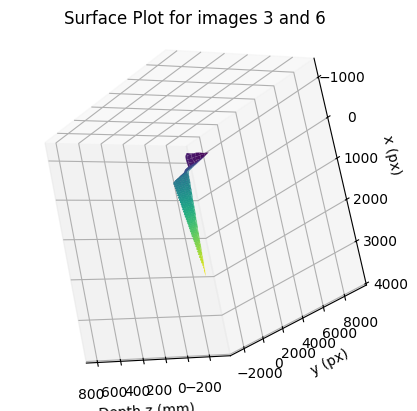

[-143  661  351   54  542  356   57  547  357   63  548  358   64  552
  360   71  559  368   71  568  366  291   76  769  -23  940  -82  565
  256  499  381  706 -127]


In [ ]:
#Try it for image 6
x2 = pd.read_csv('detections/6.csv')['x0'].to_numpy()

# Manually adjust to match points
x2[31], x2[32] = x2[32], x2[31]
x2[19], x2[20] = x2[20], x2[19]

tmp = x2.copy()

x2[26] = tmp[24]
x2[24] = tmp[25]
x2[25] = tmp[26]

x2[22] = tmp[21]
x2[23] = tmp[22]
x2[21] = tmp[23]

# calculation of depth
Z = b * f / (x2 - x1)

# 3D Position Calculation
X = (x1 - c) * (Z / f)
Y = (y - c) * (Z / f)

grid_x, grid_y = np.mgrid[min(X.flatten()):max(X.flatten()):200j, min(Y.flatten()):max(Y.flatten()):200j]
grid_z = griddata((X.flatten(), Y.flatten()), Z.flatten(), (grid_x, grid_y), method='linear')

# Plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(grid_x, grid_y, grid_z, cmap='viridis')
ax.set_xlabel("x (px)")
ax.set_ylabel("y (px)")
ax.set_zlabel("Depth z (mm)")
ax.set_title('Surface Plot for images 3 and 6')

ax.view_init(35, 70, 90)


plt.show()

print(x1-x2)

### Image 3 and 7

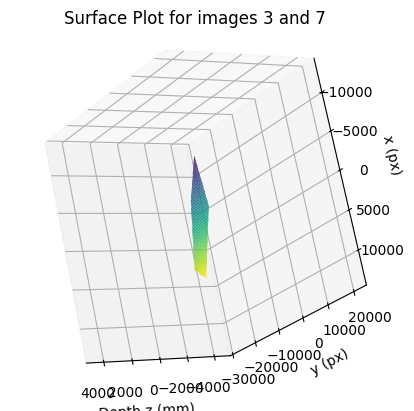

[-207  602  303   -5  486  310   -4  489  309    4  492  314    9  496
  313   12  497  324   19  504  322  325  210  436  208  438   17  504
  201  438  324  641 -189]


In [84]:
#Try it for image 7
x2 = pd.read_csv('detections/7.csv')['x0'].to_numpy()

# Manually adjust to match points
x2[31], x2[32] = x2[32], x2[31]
x2[25], x2[26] = x2[26], x2[25]
x2[21], x2[22] = x2[22], x2[21]

# calculation of depth
Z = b * f / (x2 - x1)

# 3D Position Calculation
X = (x1 - c) * (Z / f)
Y = (y - c) * (Z / f)

grid_x, grid_y = np.mgrid[min(X.flatten()):max(X.flatten()):200j, min(Y.flatten()):max(Y.flatten()):200j]
grid_z = griddata((X.flatten(), Y.flatten()), Z.flatten(), (grid_x, grid_y), method='linear')

# Plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(grid_x, grid_y, grid_z, cmap='viridis')
ax.set_xlabel("x (px)")
ax.set_ylabel("y (px)")
ax.set_zlabel("Depth z (mm)")
ax.set_title('Surface Plot for images 3 and 7')

ax.view_init(35, 70, 90)


plt.show()

print(x1-x2)

### Images 3 and 8

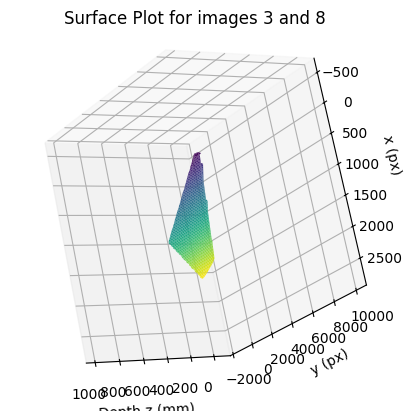

[-247  565  278  -37  450  286  -34  458  279  -30  456  282  -30  459
  281  -24  461  292  -19  465  287  280  170  397  173  402  -21  460
  167  400  277  590 -236]


In [ ]:
#Try it for image 8
x2 = pd.read_csv('detections/8.csv')['x0'].to_numpy()

# Manually adjust to match points
x2[31], x2[32] = x2[32], x2[31]
x2[25], x2[26] = x2[26], x2[25]
x2[21], x2[22] = x2[22], x2[21]

# calculation of depth
Z = b * f / (x2 - x1)

# 3D Position Calculation
X = (x1 - c) * (Z / f)
Y = (y - c) * (Z / f)

grid_x, grid_y = np.mgrid[min(X.flatten()):max(X.flatten()):200j, min(Y.flatten()):max(Y.flatten()):200j]
grid_z = griddata((X.flatten(), Y.flatten()), Z.flatten(), (grid_x, grid_y), method='linear')

# Plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(grid_x, grid_y, grid_z, cmap='viridis')
ax.set_xlabel("x (px)")
ax.set_ylabel("y (px)")
ax.set_zlabel("Depth z (mm)")
ax.set_title('Surface Plot for images 3 and 8')

ax.view_init(35, 70, 90)


plt.show()

print(x1-x2)

### Images 3 and 9

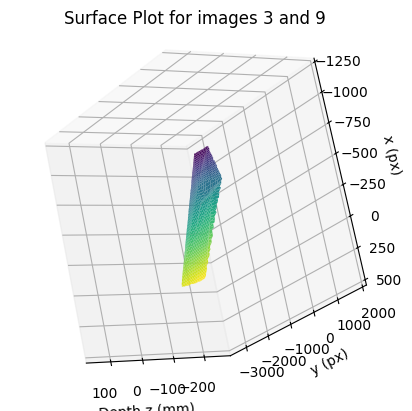

[-358  456  184 -140  347  191 -138  352  190 -131  353  194 -132  355
  194 -125  359  207 -120  365  199  181   75  300   83  302 -119  362
   72  305  182  482 -346]


In [86]:
#Try it for image 9
x2 = pd.read_csv('detections/9.csv')['x0'].to_numpy()

# Manually adjust to match points
x2[31], x2[32] = x2[32], x2[31]
x2[25], x2[26] = x2[26], x2[25]
x2[21], x2[22] = x2[22], x2[21]

# calculation of depth
Z = b * f / (x2 - x1)

# 3D Position Calculation
X = (x1 - c) * (Z / f)
Y = (y - c) * (Z / f)

grid_x, grid_y = np.mgrid[min(X.flatten()):max(X.flatten()):200j, min(Y.flatten()):max(Y.flatten()):200j]
grid_z = griddata((X.flatten(), Y.flatten()), Z.flatten(), (grid_x, grid_y), method='linear')

# Plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(grid_x, grid_y, grid_z, cmap='viridis')
ax.set_xlabel("x (px)")
ax.set_ylabel("y (px)")
ax.set_zlabel("Depth z (mm)")
ax.set_title('Surface Plot for images 3 and 9')

ax.view_init(35, 70, 90)


plt.show()

print(x1-x2)

Notice that the problem lies in the inconsistent signs of x1 - x2. Proper interpolation cannot happen if the values jump between negative and positive. This shouldn't also be happening if there is no distortion or difference in zooming between the two captures. Looking at the images, the scaling of the pictures are different. Images 6-9 are 1260 x 2160, while images 3-5 are 3024, 4032. Let's look if this issue will be fixed by manually rescaling the photos.

In [ ]:
detect_dots('pics/rescaled_3.jpg')


,x0,y0
0,135,108
1,1057,115
2,638,335
3,336,387
4,894,392


### Retry Images 3 and 6

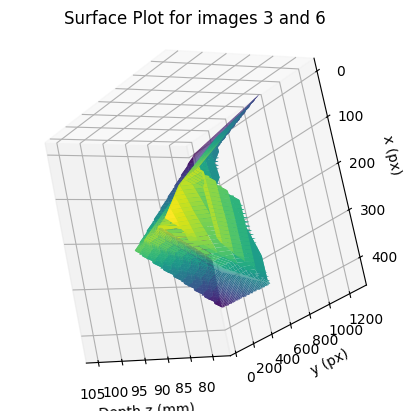

[-261 -257 -202 -237 -234 -200 -235 -230 -196 -231 -228 -196 -231 -225
 -193 -225 -218 -188 -226 -212 -187 -215 -195 -193 -217 -212 -193 -193
 -213 -220 -245]
[-261 -257 -202 -237 -234 -200 -235 -230 -196 -231 -228 -196 -231 -225
 -193 -225 -218 -188 -226 -212 -187 -215 -195 -199 -193 -198 -217 -212
 -193 -193 -213 -220 -245]


In [ ]:
x1 = pd.read_csv('detections/rescaled_3.csv')['x0'].to_numpy()
x2 = pd.read_csv('detections/6.csv')['x0'].to_numpy()

# Manually adjust to match points
x2[31], x2[32] = x2[32], x2[31]
x2[19], x2[20] = x2[20], x2[19]

tmp = x2.copy()

x2[26] = tmp[24]
x2[24] = tmp[25]
x2[25] = tmp[26]

x2[22] = tmp[21]
x2[23] = tmp[22]
x2[21] = tmp[23]

# calculation of depth
Z = b * f / (x2 - x1)

# 3D Position Calculation
X = (x1 - c) * (Z / f)
Y = (y - c) * (Z / f)

grid_x, grid_y = np.mgrid[min(X.flatten()):max(X.flatten()):200j, min(Y.flatten()):max(Y.flatten()):200j]
grid_z = griddata((X.flatten(), Y.flatten()), Z.flatten(), (grid_x, grid_y), method='linear')

# Plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(grid_x, grid_y, grid_z, cmap='viridis')
ax.set_xlabel("x (px)")
ax.set_ylabel("y (px)")
ax.set_zlabel("Depth z (mm)")
ax.set_title('Surface Plot for images 3 and 6')

ax.view_init(35, 70, 90)


plt.show()

print(x1new-x2new)
print(x1 - x2)

THAT FIXES IT!!

### Retry Images 3 and 7

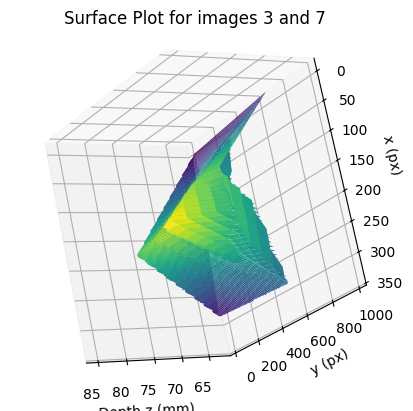

[-325 -316 -250 -296 -290 -246 -296 -288 -244 -290 -284 -240 -286 -281
 -240 -284 -280 -232 -278 -276 -231 -273 -245 -256 -245 -257 -278 -273
 -248 -254 -270 -285 -307]


In [104]:
#Try it for image 7
x2 = pd.read_csv('detections/7.csv')['x0'].to_numpy()

# Manually adjust to match points
x2[31], x2[32] = x2[32], x2[31]
x2[25], x2[26] = x2[26], x2[25]
x2[21], x2[22] = x2[22], x2[21]

# calculation of depth
Z = b * f / (x2 - x1)

# 3D Position Calculation
X = (x1 - c) * (Z / f)
Y = (y - c) * (Z / f)

grid_x, grid_y = np.mgrid[min(X.flatten()):max(X.flatten()):200j, min(Y.flatten()):max(Y.flatten()):200j]
grid_z = griddata((X.flatten(), Y.flatten()), Z.flatten(), (grid_x, grid_y), method='linear')

# Plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(grid_x, grid_y, grid_z, cmap='viridis')
ax.set_xlabel("x (px)")
ax.set_ylabel("y (px)")
ax.set_zlabel("Depth z (mm)")
ax.set_title('Surface Plot for images 3 and 7')

ax.view_init(35, 70, 90)


plt.show()

print(x1-x2)

### Retry Images 3 and 8

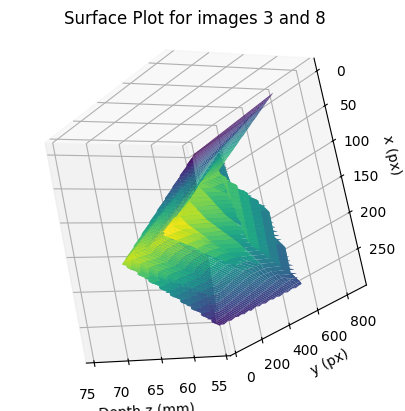

[-365 -353 -275 -328 -326 -270 -326 -319 -274 -324 -320 -272 -325 -318
 -272 -320 -316 -264 -316 -315 -266 -318 -285 -295 -280 -293 -316 -317
 -282 -292 -317 -336 -354]


In [105]:
#Try it for image 8
x2 = pd.read_csv('detections/8.csv')['x0'].to_numpy()

# Manually adjust to match points
x2[31], x2[32] = x2[32], x2[31]
x2[25], x2[26] = x2[26], x2[25]
x2[21], x2[22] = x2[22], x2[21]

# calculation of depth
Z = b * f / (x2 - x1)

# 3D Position Calculation
X = (x1 - c) * (Z / f)
Y = (y - c) * (Z / f)

grid_x, grid_y = np.mgrid[min(X.flatten()):max(X.flatten()):200j, min(Y.flatten()):max(Y.flatten()):200j]
grid_z = griddata((X.flatten(), Y.flatten()), Z.flatten(), (grid_x, grid_y), method='linear')

# Plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(grid_x, grid_y, grid_z, cmap='viridis')
ax.set_xlabel("x (px)")
ax.set_ylabel("y (px)")
ax.set_zlabel("Depth z (mm)")
ax.set_title('Surface Plot for images 3 and 8')

ax.view_init(35, 70, 90)


plt.show()

print(x1-x2)



### Retry Images 3 and 9

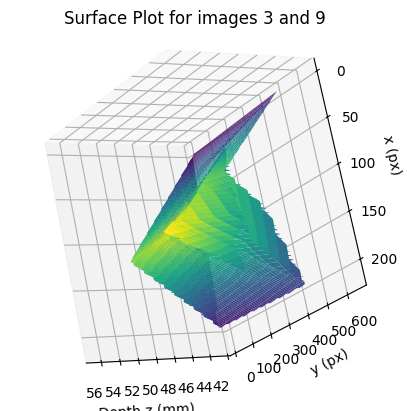

[-476 -462 -369 -431 -429 -365 -430 -425 -363 -425 -423 -360 -427 -422
 -359 -421 -418 -349 -417 -415 -354 -417 -380 -392 -370 -393 -414 -415
 -377 -387 -412 -444 -464]


In [106]:
#Try it for image 9
x2 = pd.read_csv('detections/9.csv')['x0'].to_numpy()

# Manually adjust to match points
x2[31], x2[32] = x2[32], x2[31]
x2[25], x2[26] = x2[26], x2[25]
x2[21], x2[22] = x2[22], x2[21]

# calculation of depth
Z = b * f / (x2 - x1)

# 3D Position Calculation
X = (x1 - c) * (Z / f)
Y = (y - c) * (Z / f)

grid_x, grid_y = np.mgrid[min(X.flatten()):max(X.flatten()):200j, min(Y.flatten()):max(Y.flatten()):200j]
grid_z = griddata((X.flatten(), Y.flatten()), Z.flatten(), (grid_x, grid_y), method='linear')

# Plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(grid_x, grid_y, grid_z, cmap='viridis')
ax.set_xlabel("x (px)")
ax.set_ylabel("y (px)")
ax.set_zlabel("Depth z (mm)")
ax.set_title('Surface Plot for images 3 and 9')

ax.view_init(35, 70, 90)


plt.show()

print(x1-x2)